In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
import tensorflow as tf
from os import path, remove
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
from mylibs.jupyter_notebook_helper import show_graph, renderStatsList, renderStatsCollection, \
    renderStatsListWithLabels, renderStatsCollectionOfCrossValids, plot_res_gp, my_plot_convergence
from tensorflow.contrib import rnn
from tensorflow.contrib import learn
import shutil
from tensorflow.contrib.learn.python.learn import learn_runner
from mylibs.tf_helper import getDefaultGPUconfig
from sklearn.metrics import r2_score
from mylibs.py_helper import factors
from fastdtw import fastdtw
from collections import OrderedDict
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from common_33 import get_or_run_nn
from skopt.space.space import Integer, Real
from skopt import gp_minimize
from skopt.plots import plot_convergence
import pickle
import inspect
import dill
import sys

from models.model_35_price_history_autoencoder import PriceHistoryAutoencoder
from data_providers.data_provider_33_price_history_autoencoder import PriceHistoryAutoEncDataProvider
#from gp_opt.price_history_27_gp_opt import PriceHistoryGpOpt

/home/studenthp/anaconda2/envs/dis/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
dtype = tf.float32
seed = 16011984
random_state = np.random.RandomState(seed=seed)
config = getDefaultGPUconfig()
n_jobs = 1
%matplotlib inline

### Step 0 - hyperparams

In [4]:
factors(689)

[1, 53, 13, 689]

In [5]:
max_seq_len = 682

In [6]:
#full_train_size = 55820
#train_size = 55800
#small_train_size = 6000 #just because of performance reasons, no statistics behind this decision
#test_size = 6200

In [7]:
data_path = '../../../../Dropbox/data'

In [8]:
phae_path = data_path + '/price_hist_autoencoder'

In [9]:
csv_in = '../price_history_03_seq_start_suddens_trimmed.csv'
assert path.isfile(csv_in)

In [10]:
npz_unprocessed = phae_path + '/price_history_full_seqs.npz'
assert path.isfile(npz_unprocessed)

In [11]:
npz_dates = phae_path + '/price_history_full_seqs_dates.npz'
assert path.isfile(npz_dates)

In [12]:
npz_train = phae_path + '/price_history_seqs_dates_normed_train.npz'
assert path.isfile(npz_train)

In [13]:
npz_test = phae_path + '/price_history_seqs_dates_normed_test.npz'
assert path.isfile(npz_test)

In [14]:
npz_path = npz_train[:-len('_train.npz')]

In [15]:
for key, val in np.load(npz_train).iteritems():
    print key, ",", val.shape

inputs , (689, 682, 7)
sku_ids , (689,)
sequence_masks , (689, 682)
extra_inputs , (689, 682, 6)
sequence_lengths , (689,)


### Step 1 - collect data

In [16]:
dp = PriceHistoryAutoEncDataProvider(npz_path=npz_path, batch_size=53, with_EOS=False)
for data in dp.datalist:
    print data.shape

(689, 682, 7)
(689, 682, 6)
(689,)
(689, 682)


In [17]:
# for item in dp.next():
#     print item.shape

### Step 2 - Build model

In [18]:
# model = PriceHistoryAutoencoder(rng=random_state, dtype=dtype, config=config)
# graph = model.getGraph(batch_size=53,
#                        enc_num_units = 10,
#                        dec_num_units = 10,
#                        ts_len=max_seq_len)

targets
Tensor("data/strided_slice:0", shape=(53, 682), dtype=float32)

Tensor("encoder_rnn_layer/rnn/while/Exit_2:0", shape=(?, 10), dtype=float32)

Tensor("encoder_state_out_process/Elu:0", shape=(?, 2), dtype=float32)

Tensor("decoder_state_in_process/Elu:0", shape=(?, 10), dtype=float32)

Tensor("decoder_rnn_layer/rnn/transpose:0", shape=(53, 682, 10), dtype=float32)

Tensor("decoder_outs/Reshape:0", shape=(36146, 10), dtype=float32)

Tensor("readout_affine/Identity:0", shape=(36146, 1), dtype=float32)
Tensor("readout_affine/Reshape:0", shape=(53, 682), dtype=float32)

Tensor("error/mul_1:0", shape=(53, 682), dtype=float32)

Tensor("error/Mean:0", shape=(), dtype=float32)
Tensor("error/Mean:0", shape=(), dtype=float32)

Tensor("error_diff/mul_1:0", shape=(53, 681), dtype=float32)

Tensor("error_diff/Mean:0", shape=(), dtype=float32)
Tensor("error_diff/Mean:0", shape=(), dtype=float32)

In [19]:
#show_graph(graph)

## Quick test run

In [ ]:
def experiment():
    return model.run(npz_path=npz_path,
                     epochs=2,
                     batch_size = 53,
                     enc_num_units = 400,
                     dec_num_units = 400,
                     ts_len=max_seq_len,
                     learning_rate = 1e-4,
                     preds_gather_enabled = False,
                    )
dyn_stats_dic = experiment()

In [22]:
dyn_stats_dic['dyn_stats'].plotStats()
plt.show()
dyn_stats_dic['dyn_stats_diff'].plotStats()
plt.show()

### Step 3 training the network

In [20]:
model = PriceHistoryAutoencoder(rng=random_state, dtype=dtype, config=config)

In [21]:
npz_test = npz_path + '_test.npz'
assert path.isfile(npz_test)
path.abspath(npz_test)

'/home/studenthp/Dropbox/data/price_hist_autoencoder/price_history_seqs_dates_normed_test.npz'

In [37]:
def experiment():
    return model.run(npz_path=npz_path,
                     epochs=50,
                     batch_size = 53,
                     enc_num_units = 450,
                     dec_num_units = 450,
                     ts_len=max_seq_len,
                     learning_rate = 1e-3,
                     preds_gather_enabled = True,
                    )

In [38]:
#%%time
# dyn_stats_dic, preds_dict, targets, twods = experiment()
dyn_stats_dic, preds_dict, targets, twods = get_or_run_nn(experiment, filename='035_autoencoder_001',
                                                      nn_runs_folder = data_path + "/nn_runs")

epochs: 50
dec_num_units: 450
learning_rate: 0.001
enc_num_units: 450
End Epoch 01 (114.810 secs): err(train) = 0.028195, err_diff(train) = 0.000470
End Epoch 02 (114.619 secs): err(train) = 0.006016, err_diff(train) = 0.000210
End Epoch 03 (114.573 secs): err(train) = 0.005023, err_diff(train) = 0.000173
End Epoch 04 (114.516 secs): err(train) = 0.004870, err_diff(train) = 0.000160
End Epoch 05 (114.488 secs): err(train) = 0.004861, err_diff(train) = 0.000159
End Epoch 06 (114.539 secs): err(train) = 0.004783, err_diff(train) = 0.000158
End Epoch 07 (114.465 secs): err(train) = 0.004787, err_diff(train) = 0.000158
End Epoch 08 (114.488 secs): err(train) = 0.004754, err_diff(train) = 0.000156
End Epoch 09 (114.470 secs): err(train) = 0.004738, err_diff(train) = 0.000156
End Epoch 10 (114.491 secs): err(train) = 0.004756, err_diff(train) = 0.000156
End Epoch 11 (114.505 secs): err(train) = 0.004725, err_diff(train) = 0.000155
End Epoch 12 (114.481 secs): err(train) = 0.004509, err_diff(

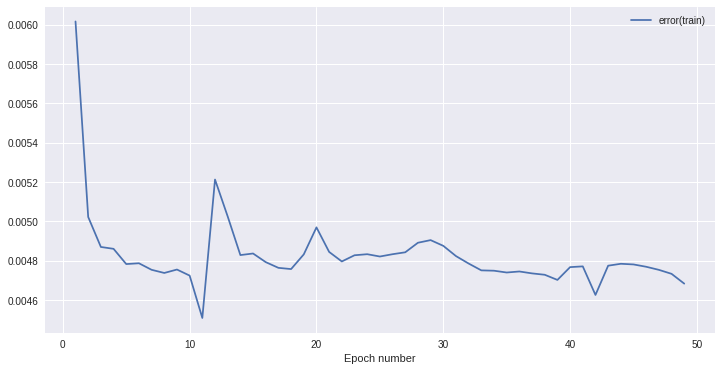

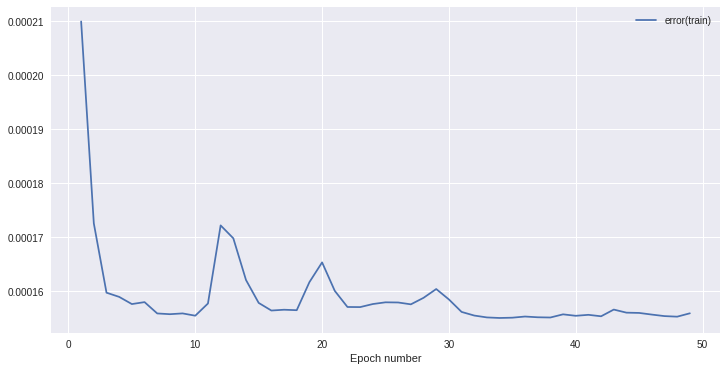

In [52]:
dyn_stats_dic['dyn_stats'].plotStats()
plt.show()
dyn_stats_dic['dyn_stats_diff'].plotStats()
plt.show()

In [53]:
r2_scores = [r2_score(y_true=targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(targets))]

In [54]:
ind = np.argmin(r2_scores)
ind

35

In [55]:
reals = targets[ind]
preds = preds_dict[ind]

In [56]:
r2_score(y_true=reals, y_pred=preds)

-41667189.193788297

In [57]:
#sns.tsplot(data=dp.inputs[ind].flatten())

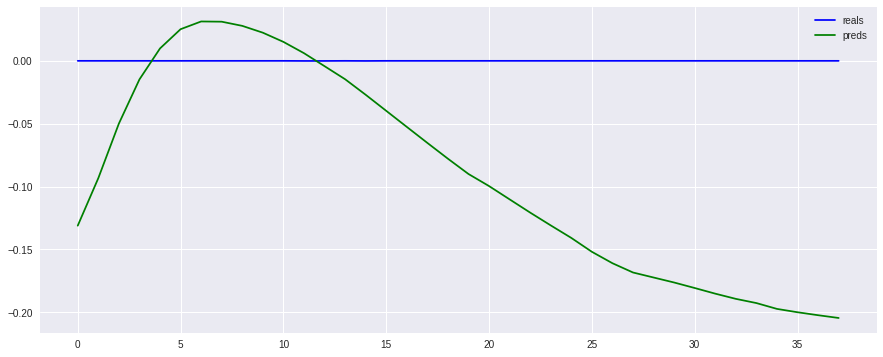

In [58]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [59]:
%%time
dtw_scores = [fastdtw(targets[ind], preds_dict[ind])[0]
             for ind in range(len(targets))]

CPU times: user 11 s, sys: 44 ms, total: 11 s
Wall time: 11 s


In [60]:
np.mean(dtw_scores)

19.136018541095279

In [61]:
coint(preds, reals)

(-0.64945719395275836,
 0.95182243204465811,
 array([-4.21692744, -3.50625177, -3.16106388]))

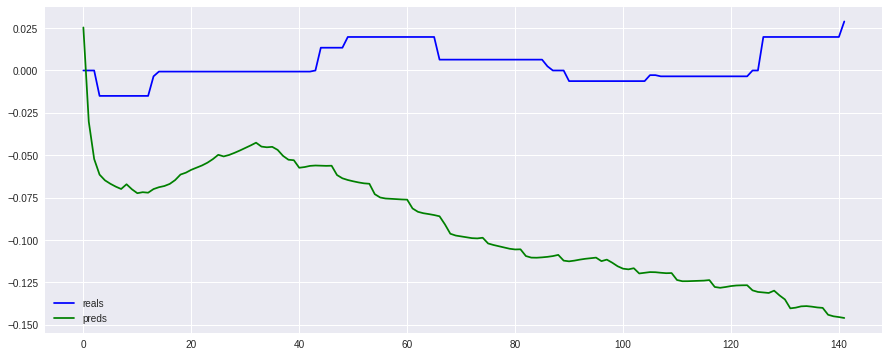

In [62]:
cur_ind = np.random.randint(len(targets))
reals = targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b', label='reals')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

### Conclusion
The autoencoder is not able to represent in a visibly obvious way our price history time series

# TS in Two Dimensions

In [63]:
twod_arr = np.array(twods.values())
twod_arr.shape

(689, 2)

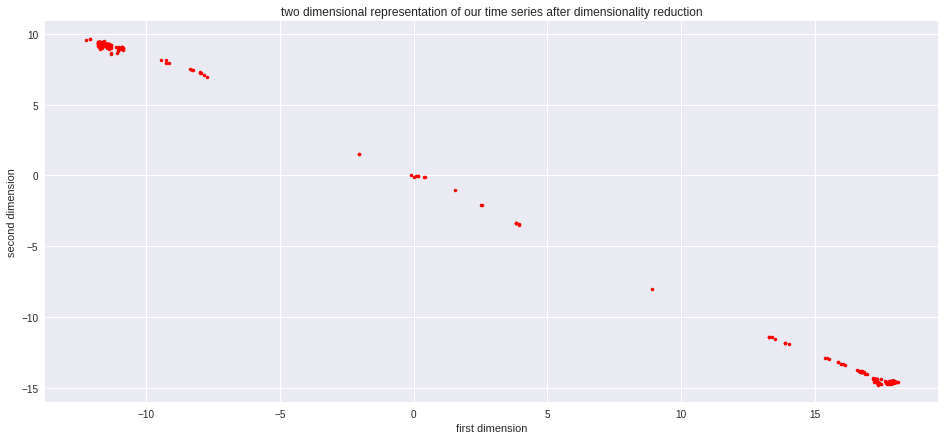

In [64]:
plt.figure(figsize=(16,7))
plt.plot(twod_arr[:, 0], twod_arr[:, 1], 'r.')
plt.title('two dimensional representation of our time series after dimensionality reduction')
plt.xlabel('first dimension')
plt.ylabel('second dimension')
plt.show()